# Team 3 - Merchant Category Recommendation
## Feature Extraction

### Team 3
- Vinicio De Sola
- Kevin Hanna
- Pri Nonis
- Bradley Nott


Here we add engineer new features and write the files out to:
    - input/engineered_train.pkl
    - input/engineered_test.pkl

In [1]:
import numpy               as np
import matplotlib.pyplot   as plt
import pandas              as pd
import seaborn             as sb

from datetime              import timedelta, datetime

from sklearn               import metrics
from sklearn.decomposition import PCA
from sklearn.cluster       import KMeans
from sklearn.mixture       import GaussianMixture
from sklearn.linear_model  import LinearRegression

from matplotlib.colors     import LogNorm

from IPython.display       import HTML, Markdown

from sklearn.metrics       import mean_squared_error

%matplotlib inline

np.random.seed(0)

import os
print(os.listdir("./input"))

['historical_transactions.csv', '.ipynb_checkpoints', 'new_merchant_transactions.csv', 'engineered_test.pkl', '.~lock.Data_Dictionary.xlsx#', 'merchants.csv', 'sample_submission.csv', 'test.csv', 'Data_Dictionary.xlsx', 'engineered_train.pkl', '.gitignore', 'train.csv']


## Read in all the data files

In [2]:
train        = pd.read_pickle('input/engineered_train.pkl')
test         = pd.read_pickle('input/engineered_test.pkl')

target = train['target']
del train['target']

## A view of our new training data dataframe

In [3]:
display(train.head())
display(test.head())

,feature_3,first_active_delta_days,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,...,new_category_2_5.0_sum,new_category_3_A_sum,new_category_3_B_sum,new_category_3_C_sum,new_authorized_flag_y_sum,new_authorized_flag_n_sum,new_month_diff_mean,new_month_diff_min,new_month_diff_max,new_month_diff_std
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_92a2005557,1,246,0,0,0,0,1,0,1,0,...,0.0,23.0,0.0,0.0,23.0,0.0,13.521739,13.0,14.0,0.510754
C_ID_3d0044924f,0,397,0,0,0,1,0,1,0,0,...,0.0,0.0,6.0,0.0,6.0,0.0,14.500000,14.0,15.0,0.547723
C_ID_d639edf6cd,0,550,0,1,0,0,0,0,1,0,...,1.0,1.0,0.0,0.0,1.0,0.0,13.000000,13.0,13.0,0.000000
C_ID_186d6a6901,0,154,0,0,0,1,0,0,0,1,...,0.0,0.0,6.0,0.0,7.0,0.0,13.571429,13.0,14.0,0.534522
C_ID_cdbd2c0db2,0,93,1,0,0,0,0,0,0,1,...,0.0,0.0,34.0,1.0,36.0,0.0,13.611111,13.0,14.0,0.494413


,first_active_month,feature_3,first_active_delta_days,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,...,new_category_2_5.0_sum,new_category_3_A_sum,new_category_3_B_sum,new_category_3_C_sum,new_authorized_flag_y_sum,new_authorized_flag_n_sum,new_month_diff_mean,new_month_diff_min,new_month_diff_max,new_month_diff_std
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_0ab67a22ab,2017-04-01,1,307,0,0,1,0,0,0,0,...,0.0,0.0,2.0,1.0,3.0,0.0,15.333333,15.0,16.0,0.577350
C_ID_130fd0cbdd,2017-01-01,0,397,0,1,0,0,0,0,0,...,0.0,0.0,8.0,1.0,9.0,0.0,13.777778,13.0,14.0,0.440959
C_ID_b709037bc5,2017-08-01,1,185,0,0,0,0,1,1,0,...,1.0,0.0,1.0,1.0,2.0,0.0,14.000000,14.0,14.0,0.000000
C_ID_d27d835a9f,2017-12-01,0,63,0,1,0,0,0,1,0,...,1.0,0.0,5.0,5.0,10.0,0.0,13.600000,13.0,14.0,0.516398
C_ID_2b5e3df5c2,2015-12-01,1,794,0,0,0,0,1,1,0,...,0.0,0.0,4.0,1.0,6.0,0.0,14.000000,14.0,14.0,0.000000


# Feature Extraction
Analyze and select features for modeling

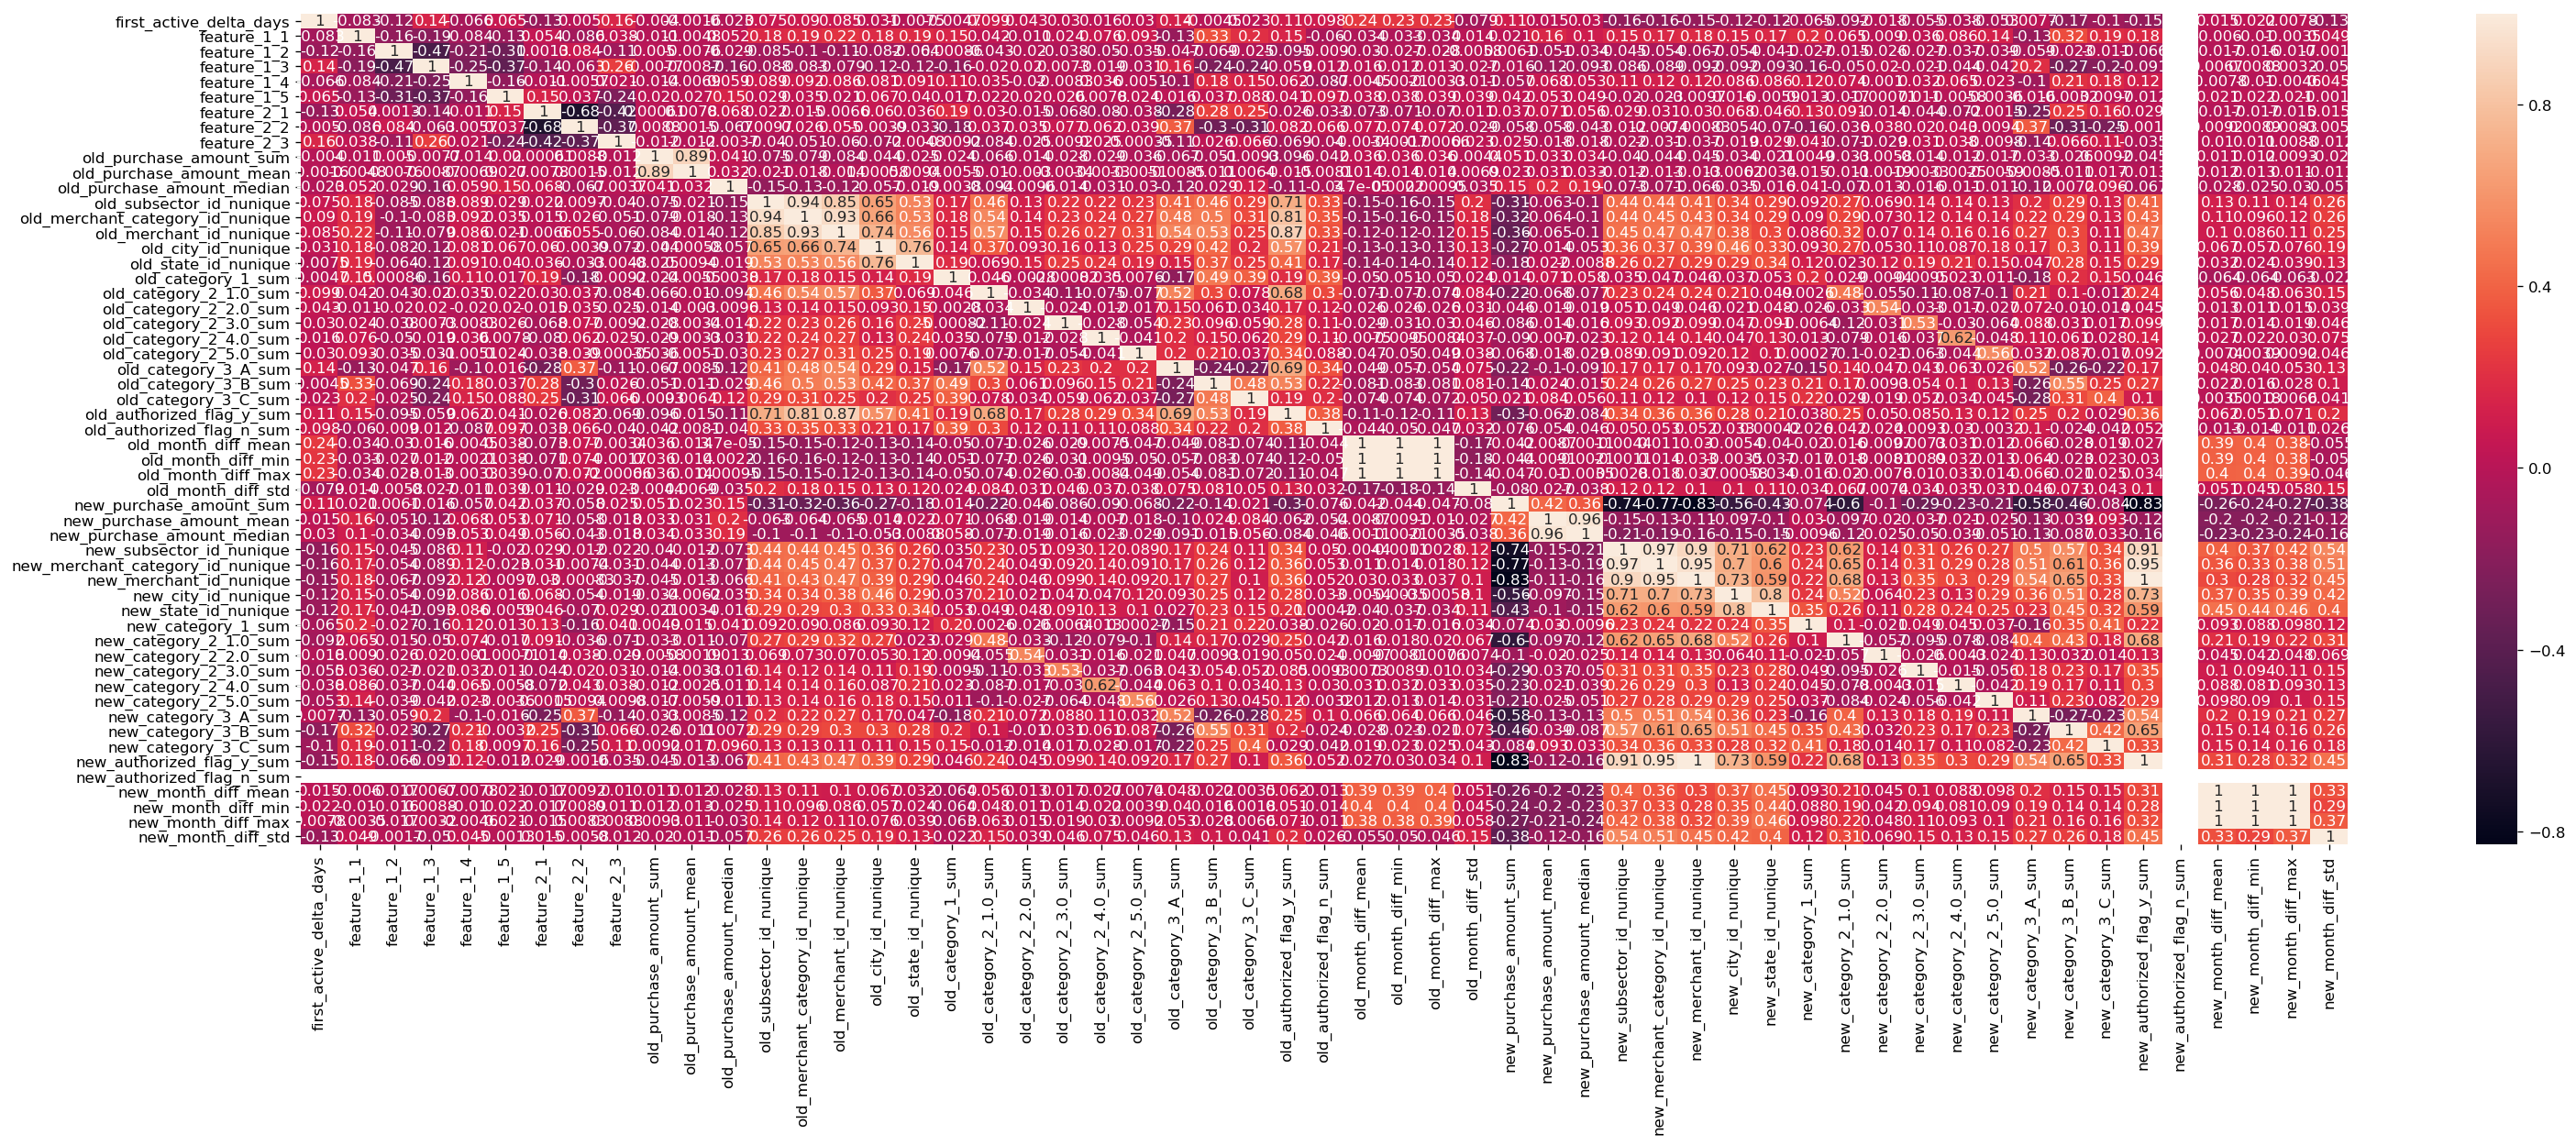

In [4]:
train_sm = train[train.columns[1:]][:5000]
corr = train_sm.corr()
plt.figure(num=None, figsize=(30,10), dpi=120, facecolor='w', edgecolor='k')
sb.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True
          )

# Note the strong negative correlations to new_purchase_amount_sum. 
# I suspect this is because of the zero filled values when we joined
# train with transactions_new (which don't line up 1:1)

# When we reduce features this will be less ugly again

In [5]:
train_sm = train[train.columns[1:]][:10]
cov = np.cov(train_sm, ddof=1)
display(pd.DataFrame(cov))


,0,1,2,3,4,5,6,7,8,9
0,4976.857262,5230.437590,2747.019680,1184.564865,1093.036089,2463.455848,4542.823011,875.728447,880.423535,3994.009205
1,5230.437590,8898.906181,4094.573953,2138.010404,2215.407495,4010.445074,4960.408987,1216.266975,1475.760159,5314.893826
2,2747.019680,4094.573953,5536.706374,1549.965990,907.900050,5151.589765,4758.433797,1546.050250,1834.799720,5592.097998
3,1184.564865,2138.010404,1549.965990,723.135432,732.365997,1471.989257,1603.020442,470.168840,542.424413,1713.597576
4,1093.036089,2215.407495,907.900050,732.365997,1019.816988,868.533560,1274.354962,309.393935,337.385959,1121.467355
5,2463.455848,4010.445074,5151.589765,1471.989257,868.533560,4886.811771,4041.732741,1448.065377,1742.201255,5219.651223
6,4542.823011,4960.408987,4758.433797,1603.020442,1274.354962,4041.732741,7215.043768,1355.909214,1441.263834,5291.210697
7,875.728447,1216.266975,1546.050250,470.168840,309.393935,1448.065377,1355.909214,454.628121,522.430401,1602.084437
8,880.423535,1475.760159,1834.799720,542.424413,337.385959,1742.201255,1441.263834,522.430401,629.009326,1859.955941
9,3994.009205,5314.893826,5592.097998,1713.597576,1121.467355,5219.651223,5291.210697,1602.084437,1859.955941,6108.462382


## Train and test model using ALL engineered features 

In [6]:
train.columns

Index(['feature_3', 'first_active_delta_days', 'feature_1_1', 'feature_1_2',
       'feature_1_3', 'feature_1_4', 'feature_1_5', 'feature_2_1',
       'feature_2_2', 'feature_2_3', 'old_purchase_amount_sum',
       'old_purchase_amount_mean', 'old_purchase_amount_median',
       'old_subsector_id_nunique', 'old_merchant_category_id_nunique',
       'old_merchant_id_nunique', 'old_city_id_nunique',
       'old_state_id_nunique', 'old_category_1_sum', 'old_category_2_1.0_sum',
       'old_category_2_2.0_sum', 'old_category_2_3.0_sum',
       'old_category_2_4.0_sum', 'old_category_2_5.0_sum',
       'old_category_3_A_sum', 'old_category_3_B_sum', 'old_category_3_C_sum',
       'old_authorized_flag_y_sum', 'old_authorized_flag_n_sum',
       'old_month_diff_mean', 'old_month_diff_min', 'old_month_diff_max',
       'old_month_diff_std', 'new_purchase_amount_sum',
       'new_purchase_amount_mean', 'new_purchase_amount_median',
       'new_subsector_id_nunique', 'new_merchant_category_id_nu

## Test area to play with different sets of features

In [7]:
def feature_play():
    np.random.seed(0)
    #This is just to play around with different engineered features. 

    
    training = train[[
        # Train
        'feature_3',
        'first_active_delta_days',
        'feature_1_1', 
        'feature_1_2', 
        'feature_1_3', 
        'feature_1_4',
        'feature_1_5', 
        'feature_2_1', 
        'feature_2_2', 
        'feature_2_3',
        
        # Old
        'old_purchase_amount_sum', 
        'old_purchase_amount_mean',
#         'old_purchase_amount_median', # Mean is better than Median
        'old_subsector_id_nunique',
        'old_merchant_category_id_nunique', 
        'old_merchant_id_nunique',
        'old_city_id_nunique', 
        'old_state_id_nunique', 
        'old_category_1_sum',
        'old_category_2_1.0_sum', 
        'old_category_2_2.0_sum',
        'old_category_2_3.0_sum', 
        'old_category_2_4.0_sum',
        'old_category_2_5.0_sum', 
        'old_category_3_A_sum',
        'old_category_3_B_sum', 
        'old_category_3_C_sum',
        'old_authorized_flag_y_sum',
        'old_authorized_flag_n_sum',
        'old_month_diff_mean', 
        'old_month_diff_min', 
        'old_month_diff_max',
        'old_month_diff_std',
        
        # New
        'new_purchase_amount_sum', 
        'new_purchase_amount_mean',
#         'new_purchase_amount_median', 
        'new_subsector_id_nunique',
        'new_merchant_category_id_nunique', 
        'new_merchant_id_nunique',
        'new_city_id_nunique', 
        'new_state_id_nunique', 
        'new_category_1_sum',
        'new_category_2_1.0_sum', 
        'new_category_2_2.0_sum',
        'new_category_2_3.0_sum', 
        'new_category_2_4.0_sum',
        'new_category_2_5.0_sum', 
        'new_category_3_A_sum',
        'new_category_3_B_sum', 
        'new_category_3_C_sum',
        'new_authorized_flag_y_sum',
        'new_authorized_flag_n_sum',
        'new_month_diff_mean', 
        'new_month_diff_min', 
        'new_month_diff_max',
        'new_month_diff_std'
    ]]
    
    
    data_len = len(train)
    mask = np.random.rand(data_len) < 0.8

    train_data = train.values[mask]
    train_labels = target.values.flatten()[mask]
    test_data = train.values[~mask]
    test_labels = target.values.flatten()[~mask]

    X = train_data
    y = train_labels

    X_test = test_data
    y_test = test_labels

    reg = LinearRegression()
    reg.fit(X, y)

    y_pred_reg = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_reg)

    y_mean = train_labels.mean()
    y_test_mean = test_labels.mean()

    print("Using the following features, the Mean Squared Error is: {:0.3f}".format(mse))
    print(training.columns)
    
    return mse

# if play_mse:
#     print("Previous MSE: {:0.3f}".format(play_mse))
    
play_mse = feature_play()

Using the following features, the Mean Squared Error is: 13.902
Index(['feature_3', 'first_active_delta_days', 'feature_1_1', 'feature_1_2',
       'feature_1_3', 'feature_1_4', 'feature_1_5', 'feature_2_1',
       'feature_2_2', 'feature_2_3', 'old_purchase_amount_sum',
       'old_purchase_amount_mean', 'old_subsector_id_nunique',
       'old_merchant_category_id_nunique', 'old_merchant_id_nunique',
       'old_city_id_nunique', 'old_state_id_nunique', 'old_category_1_sum',
       'old_category_2_1.0_sum', 'old_category_2_2.0_sum',
       'old_category_2_3.0_sum', 'old_category_2_4.0_sum',
       'old_category_2_5.0_sum', 'old_category_3_A_sum',
       'old_category_3_B_sum', 'old_category_3_C_sum',
       'old_authorized_flag_y_sum', 'old_authorized_flag_n_sum',
       'old_month_diff_mean', 'old_month_diff_min', 'old_month_diff_max',
       'old_month_diff_std', 'new_purchase_amount_sum',
       'new_purchase_amount_mean', 'new_subsector_id_nunique',
       'new_merchant_category_i